### CUNY Data 620 - Web Analytics, Summer 2020  
**Final Project**   
**Prof:** Alain Ledon  
**Members:** Misha Kollontai, Amber Ferger, Zach Alexander, Subhalaxmi Rout 

**Youtube Link:** 

### Instructions
Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 

### Research Purpose

For this project, we will be pulling twitter data related to the Coronavirus pandemic in the United States. Our primary objective will be to identify the relationship between city and overall sentiment towards covid. We will look at the average daily tweet sentiment for **NYC** (severe initial wave) and **New Orleans** (experiencing something of a second wave) to see if there are regional differences. From this, we would like to answer the following questions:

* Is there a relationship between location-specific Covid-19 sentiment and the number of positive cases within that region?
* Does positive sentiment preceed spikes in positive cases?

As a secondary objective, we would like to identify relationships between major US cities by looking at shared tweet hashtags. We aim to create a network from these relationships where nodes represent cities and edges represent shared use of hashtags. In doing this, we would like to answer the following questions:

* What issues (additional hashtags) are discussed in conjunction with Covid-19?
* What differences in hashtag use is there across the country?
* Are there certain cities that care about similar issues (additional hashtags)?

As a stretch goal, we would also like to answer the question: Is there a relationship between location-specific Covid-19 hashtags and the number of positive cases within that region? 

### The Data

#### Relevant Cities
First, we generated a list of geocodes that related to the most populous city in each US state (plus DC). This data was pulled from the [1000 Largest US Cities By Population With Geographic Coordinates](https://public.opendatasoft.com/explore/dataset/1000-largest-us-cities-by-population-with-geographic-coordinates/table/?sort=-rank). 


#### Covid-Tweets
Our initial plan was to use the Twitter API to pull in relevant tweets, but we later realized that the API only allows users to pull back 5 days worth of data. Because of this, we turned to the [*GetOldTweets3*](https://pypi.org/project/GetOldTweets3/) package, which allowed us to return tweets with the following specifications:

* **Date Range**: 3/8/2020 - 7/15/2020, pulled in biweekly groupings by city.
* The tweet itself contains the word **Covid** or it is included in one of the hashtags.
* The limit on the total number of tweets per API call is 1000 per date increment. Some of our cities had the full 1000 tweets while others contained less. 

Our final output includes: tweet text, additional hashtags, tweet date, twitter username, and city coordinates. 

Please see the **tweetPull** notebook for more information about the the extraction of relevant tweets. 


#### Covid Case Numbers

We used [John's Hopkins COVID-19 Data](https://github.com/CSSEGISandData/COVID-19) and [Wikipedia](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_United_States) for the COVID-19 numbers. 

### Libraries

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#from mpl_toolkits.basemap import Basemap
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

### Data
First, we'll pull in our twitter and our covid cases data. Since our first set of research questions are focused only on New York and New Orleans, we will create separate dataframes for this information. 

#### Twitter Data
We can see that each state has 1000 tweets within the timeframe.

In [2]:
# read in and replace nulls
tweets = pd.read_csv('Covid_Twitter_City_Data.csv', delimiter=',')
tweets = tweets.replace(np.nan, '', regex=True)

nyTweets = tweets[tweets["City"] == "New York"]
noTweets = tweets[tweets["City"] == "New Orleans"]

print('Number of NY tweets: ', nyTweets.shape)
print('Number of New Orleans tweets: ',noTweets.shape)
# nyTweets['Date'].min()

Number of NY tweets:  (1000, 9)
Number of New Orleans tweets:  (1000, 9)


##### Covid Case Data

We'll filter by FIPS code, transpose the data to create the proper format, reset the index, and adjust the datetype. 

We can take a quick look at the last 5 dates for NYC dataset:

In [3]:
# load in covid case data
covid_cases = pd.read_csv('confirmed_cases.csv')

########## NYC cases
cases_filtered = covid_cases[covid_cases['FIPS'] == 36061]
df = cases_filtered.iloc[:, 11:186:1]

df = df.transpose().reset_index()
df = df.rename(columns={'index': 'Date', 1863: "Confirmed_Cases"})

nyc_time_series = pd.DataFrame(df, columns = ['Date','Confirmed_Cases'])
nyc_time_series['Date'] = pd.to_datetime(nyc_time_series['Date'], format='%m/%d/%y')

nyc_time_series.tail()

,Date,Confirmed_Cases
170,2020-07-10,218403
171,2020-07-11,218710
172,2020-07-12,219051
173,2020-07-13,219301
174,2020-07-14,219616


And also for New Orleans:

In [4]:
########## New Orleans cases
cases_filtered_newo = covid_cases[covid_cases['FIPS'] == 22071]
df_newo = cases_filtered_newo.iloc[:, 11:186:1]

df_newo = df_newo.transpose().reset_index()
df_newo = df_newo.rename(columns={'index': 'Date', 1153: "Confirmed_Cases"})

newo_time_series = pd.DataFrame(df_newo, columns = ['Date','Confirmed_Cases'])
newo_time_series['Date'] = pd.to_datetime(newo_time_series['Date'], format='%m/%d/%y')

newo_time_series.tail()

,Date,Confirmed_Cases
170,2020-07-10,8476
171,2020-07-11,8598
172,2020-07-12,8665
173,2020-07-13,8745
174,2020-07-14,8846


Next, we'll define some custom functions to visualize the data. 

In order to find the number of new cases per day, we can utilize our confirmed cases column to take the difference between the current day and the previous day. Additionally, for our visualization, we can take the 7-day average of new cases and plot this as well, in order to obtain a better view of trends over time. We can also create a function to plot the case counts. 

In [5]:
############### New cases per day
def add_newcases(df):
    df['New_Cases'] = 'NA'
    for i in range(0, len(df['Confirmed_Cases'])):
        if i == 0:
            df['New_Cases'][i] = 0
        else:
            df['New_Cases'][i] = df['Confirmed_Cases'][i] - df['Confirmed_Cases'][i-1]
    return df

############### Seven day averages
def add_sevenday(df):
    df['Seven_Day_Avg'] = 'NA'
    for i in range(0, len(df['Confirmed_Cases'])):
        if i < 8:
            df['Seven_Day_Avg'][i] = 0
        else:
            weekly = []
            for y in range(0,7):
                weekly.append(df['New_Cases'][i-y])
            df['Seven_Day_Avg'][i] = sum(weekly) / 7
    return df

############### Plot case counts 
def drawNewCases(df, title, fignum, var):
    var = plt.figure(fignum, figsize=(16,8))
    plt.bar(df['Date'], df['New_Cases'], color='indianred', alpha=0.4)
    plt.plot(df['Date'], df['Seven_Day_Avg'], c='indianred', linewidth=2)
    plt.plot(legend=None)
    plt.title(title)
    plt.ylabel('Number of New Cases')
    plt.gca().xaxis.set_major_formatter(fmt)
    var.show()

We can now plot the daily cases by city: 

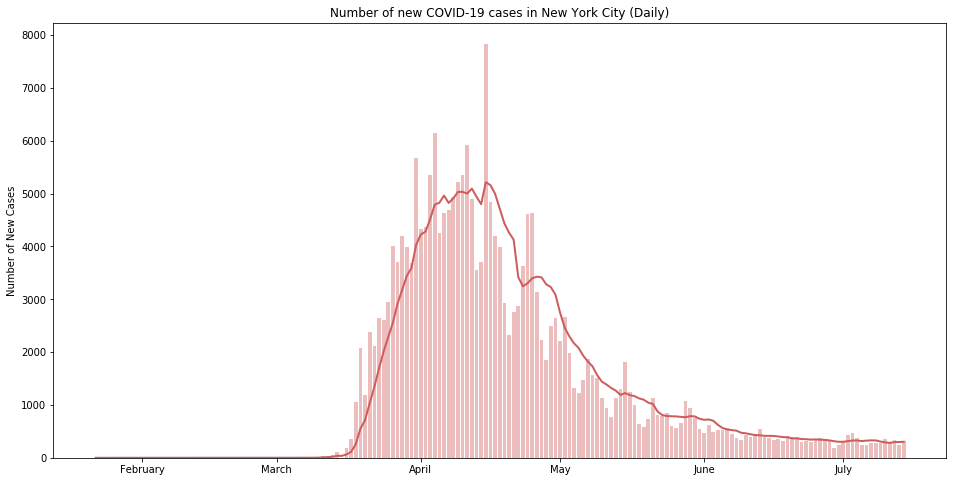

In [6]:
# calculate new cases per day and seven day averages
df = add_newcases(nyc_time_series)
df = add_sevenday(df)

# plot counts
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%B')

nyc_time_series = pd.DataFrame(df, columns = ['Date','Confirmed_Cases', 'New_Cases', 'Seven_Day_Avg'])
nyc_time_series['Date'] = pd.to_datetime(nyc_time_series['Date'], format='%m/%d/%y')

drawNewCases(nyc_time_series, 'Number of new COVID-19 cases in New York City (Daily)', 1, 'x')

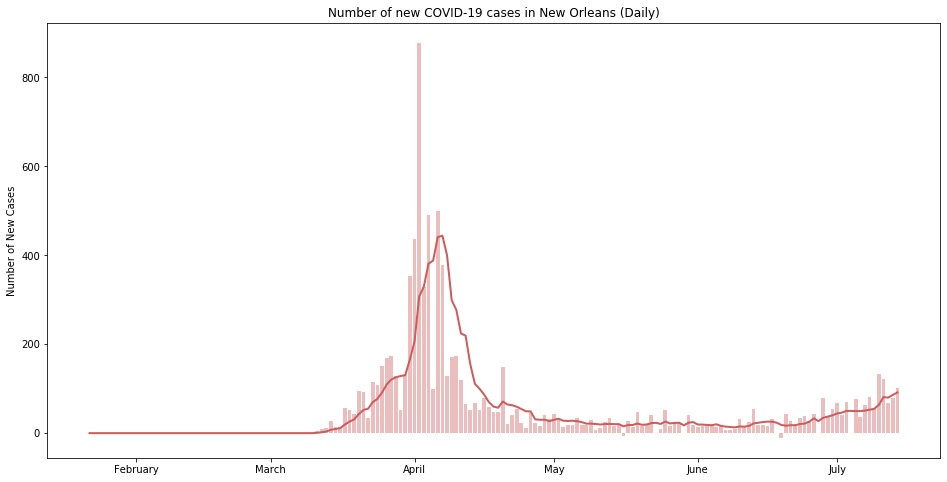

In [7]:
df_newo = add_newcases(newo_time_series)
df_newo = add_sevenday(df_newo)

newo_time_series = pd.DataFrame(df_newo, columns = ['Date','Confirmed_Cases', 'New_Cases', 'Seven_Day_Avg'])
newo_time_series['Date'] = pd.to_datetime(newo_time_series['Date'], format='%m/%d/%y')

drawNewCases(newo_time_series, 'Number of new COVID-19 cases in New Orleans (Daily)', 2, 'y')

### Sentiment Analysis

In order to capture the sentiment of our tweets, we'll use the *vaderSentiment* package. We will define a customized function that returns the negative, positive, neutral, and compound scores of the given tweet. We'll also define a function that will format the final output of the sentiment analysis.

In [8]:
############### sentiment analysis
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    neg = score['neg']
    pos = score['pos']
    neu = score['neu']
    compound= score['compound']
    
    return [neg,pos,neu,compound, sentence]

############### analysis formatting
def formatSentiment(ls, df):
    sents = [sentiment_analyzer_scores(s) for s in ls]
    sentDf = pd.DataFrame(sents, columns = ['NEGATIVE_SCORE', 'POSITIVE_SCORE', 'NEUTRAL_SCORE', 'COMPOUND', 'SENTENCE'])
    final = df.join(sentDf)
    return final.iloc[:,1:-1]

We can then apply this function to our twitter dataframe and separate by city. 

In [9]:
finalSentiment = formatSentiment(text, tweets)

no1 = finalSentiment[finalSentiment["City"] == "New Orleans"]
ny1 = finalSentiment[finalSentiment["City"] == "New York"]

NameError: name 'text' is not defined

In [10]:
#ny1.sort_values(by=['POSITIVE_SCORE'], ascending=False).head(10)

### Creating a Network
* **Nodes**: Cities, **TO DO: color: sentiment, size: portion of population affected by covid**
* **Edges**: Shared Hashtags, **TO DO: edge weights: number of shared hashtags**

#### Hashtags by Coordinate
First, we'll define 2 functions that will help to format our hashtag data. The first will be used to split the hashtag column into separate entities and the second will be used to create a final edge list for our network.

In [11]:
############### splitting hashtag groupings
def splitTags(x,y):
    return [(x,z) for z in y]

############### create edge list
def createEdges(ls):    
    productList = []
    
    for i in ls:
        if len(i) >1:
            productList.append(list(combinations(i,2)))
    
    return [val for sublist in productList for val in sublist]

In [12]:
# hashtags & coordinates for each record
hashtags = tweets['HASHTAGS'].tolist()
coords = tweets['COORDS'].tolist()
sepHash = [i.split() for i in hashtags]
sepHash[1:5]

[[], [], [], ['#CX', '#COVID', '#custserv']]

In [13]:
# set of all coordinates with individual hashtag
coordTag = [splitTags(i,j) for i,j in list(zip(coords,sepHash)) if len(j)> 0]
flattened = [val for sublist in coordTag for val in sublist]
finalHash = set(flattened)

# create a dictionary of each hashtag with the city coordinates
tempDict = {}
for i,j in finalHash:
    if j not in tempDict:
        tempDict[j]= [i]
    else:
        tempDict[j].append(i)
        
# remove covid hashtags from dictionary
tagsToRemove = ['#covid_19', '#COVID19', '#COVID2019', '#COVID_19', '#COVID__19', '#COVID', '#CoronavirusUSA', '#CV19',
                '#COVD19', '#Covid_19', '#CORONAVIRUS', '#Coronavirus', '#CoronavirusCOVID', '#Corona', '#Coronovirus',
               '#CoronavirusOubreak', '#CoronavirusPandemic', '#CoronavirusOutbreak', '#CoronavirusPandemic', '#coronavirus', 
                '#Covid19', '#covid', '#Covid', '#covid19', '#pandemic', '#corona']

for k in tagsToRemove:
    tempDict.pop(k, None)

print('Example output from the hashtag #FollowTheScience:')
tempDict['#FollowTheScience']

Example output from the hashtag #FollowTheScience:


['41.8781136,-87.6297982',
 '47.6062095,-122.3320708',
 '34.0522342,-118.2436849',
 '39.9525839,-75.1652215',
 '39.7392358,-104.990251',
 '34.7464809,-92.2895948',
 '39.9611755,-82.9987942',
 '38.9071923,-77.0368707']

In [14]:
len(tempDict['#VoteBlueToSaveAmerica2020'])
#sorted(tempDict['#BlackLivesMatter'])

#list(set(tempDict['#VoteBlueToSaveAmerica2020']) & set(tempDict['#BlackLivesMatter']))


print('business: ' , len(tempDict['#business']))
print('stay home: ' , len(tempDict['#stayhome']))
print('both: ', len(set(tempDict['#business']) & set(tempDict['#stayhome'])))

business:  15
stay home:  13
both:  5


#### Top Hashtags 
Let's take a look at the hashtags used in the highest number of cities. #WearAMask and #COVIDIOTS in particular stand out. 

In [15]:
# top hashtags
hsh = []
ties = []
for key, value in tempDict.items():
    hsh.append(key)
    ties.append(len(value))
Hash_Ties = pd.DataFrame()
Hash_Ties['Hashtag'] = hsh
Hash_Ties['Cities'] = ties
Hash_Ties = Hash_Ties.sort_values(by=['Cities'],ascending = False)
Hash_Ties.head(10)

,Hashtag,Cities
1215,#WearAMask,41
126,#COVIDIOTS,32
261,#TMobileTuesdays,28
84,#TrumpVirus,27
489,#SmartNews,27
1007,#contest,27
51,#BlackLivesMatter,26
356,#SocialDistancing,26
54,#WearADamnMask,25
874,#MaskUp,25


In [16]:
#### Final Edges
# combining all elements in the dictionary values into separate node connections
coordPairs = list(tempDict.values())
finalPairs = createEdges(coordPairs)

print('Example Edge:', finalPairs[1])

Example Edge: ('38.9071923,-77.0368707', '39.9525839,-75.1652215')


In [17]:
city_data = pd.read_csv('covid_cases_citypop.csv')
city_data.head()

,City,State,Long Name,FIPS,Rank,Population,Lat,Long,1/22/2020,1/23/2020,...,7/5/2020,7/6/2020,7/7/2020,7/8/2020,7/9/2020,7/10/2020,7/11/2020,7/12/2020,7/13/2020,7/14/2020
0,New York,New York,"New York, New York, US",36061,1,8405837,40.712784,-74.005941,0,0,...,216969,217216,217488,217777,218052,218403,218710,219051,219301,219616
1,Los Angeles,California,"Los Angeles, California, US",6037,2,3884307,34.052234,-118.243685,0,0,...,115024,116570,120764,123256,124992,127439,130394,133549,136357,140576
2,Chicago,Illinois,"Chicago, Illinois, US",17031,3,2718782,41.878114,-87.629798,0,0,...,92532,92781,93053,93496,94005,94605,95138,95557,95884,96186
3,Houston,Texas,"Houston, Texas, US",48201,4,2195914,29.760427,-95.369803,0,0,...,36597,37776,39311,40012,40918,41999,43939,45368,47369,49027
4,Philadelphia,Pennsylvania,"Philadelphia, Pennsylvania, US",42101,5,1553165,39.952584,-75.165222,0,0,...,26565,26810,26901,26969,27228,27341,27367,27367,27575,27723


#### Visualize Network

First, we'll define a function to split the coordinates into their respective latitude and longitude values.

In [18]:
Node = {}

for idx, row in city_data.iterrows():
    city = row['City']
    if city not in Node:
        attr = {}
        lat = row['Lat']
        long = row['Long']
        pop = int(row['Population'])

        cases = int(row['7/14/2020'])
        attr['pos'] =  (float(long),float(lat))
        attr['pop'] = int(pop/1000)
        attr['cases'] = int(cases)
        attr['cas_per_pop'] = round(cases/pop,5)
        Node[city] = attr

In [19]:
def unpack_lat_long(lat_long):
    split = lat_long.split(',')
    lat = split[0]
    long = split[1]
    return lat, long

def find_coord_of_hash(hash):
    search = hash.lower()
    coords = []
    for key, value in tempDict.items():
        if key.lower() == search:
            for coord in value:
                coords.append(coord) 
    lat_lst = []
    long_lst = []
    for city in coords:
        lat, long = unpack_lat_long(city)
        lat_lst.append(round(float(lat),2))
        long_lst.append(round(float(long),2))
    return coords, lat_lst, long_lst   

In [20]:
#https://www.geeksforgeeks.org/python-program-to-count-duplicates-in-a-list-of-tuples/
def count(listOfTuple): 
    count_map = {} 
    for i in listOfTuple: 
        count_map[i] = count_map.get(i, 0) +1
    #print(count_map) 
    return count_map
x = count(finalPairs)

In [21]:
w_edges = []
for key, value in x.items():
    w_edges.append(key + (value,))


In [22]:
def coord_to_cities(node):
    split = node.split(',')
    lat = split[0]
    long = split[1]
    lat = round(float(lat),4)
    long = round(float(long),4)
    for idx, row in city_data.iterrows():
        if lat == round(row['Lat'],4) and long == round(row['Long'],4):
            return row['City']

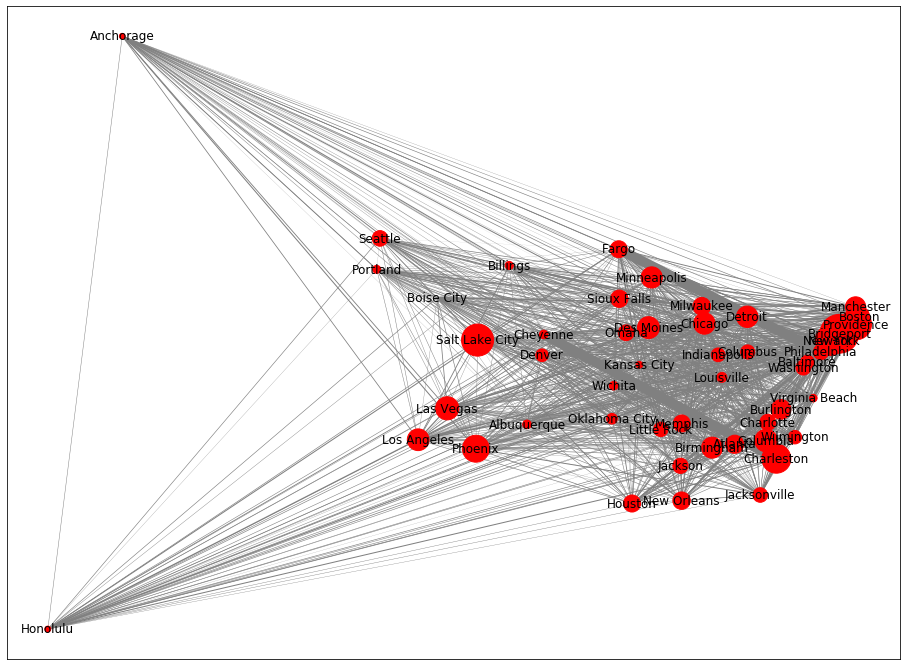

In [23]:
G = nx.Graph()
G.add_weighted_edges_from(w_edges)
node_name_map = {}
for node in G.nodes:
    city= coord_to_cities(node)
    node_name_map[node] = city
G = nx.relabel_nodes(G, node_name_map)
nx.set_node_attributes(G, Node)
Gpos=nx.get_node_attributes(G,'pos')
case_per_pop = list(nx.get_node_attributes(G,'cas_per_pop').values())
cmin, cmax = min(case_per_pop), max(case_per_pop)
for i, val in enumerate(case_per_pop):
    case_per_pop[i] = ((val-cmin) / (cmax-cmin))*1500
    
thick = []
color=[]
for edge in w_edges:
    thick.append(edge[2])
tmin, tmax = min(thick), max(thick)
for i, val in enumerate(thick): 
    thick[i] = (val-tmin) / (tmax-tmin)*10
    #color.append (((val-tmin) / (tmax-tmin),(val-tmin) / (tmax-tmin),(val-tmin) / (tmax-tmin)))

plt.figure(1, figsize=(16,12))
nx.draw_networkx(G, pos = Gpos,node_size = case_per_pop, node_color = 'red',with_labels = True, font_size = 12,edge_color ='grey', width = thick)
plt.show()

### Edge Weights
https://www.geeksforgeeks.org/python-program-to-count-duplicates-in-a-list-of-tuples/

**Note from Zach**: Will remove this commented-out code later (see below), but thought I'd leave it just in case it'll be helpful for future visualizations:

In [ ]:
# locator = mdates.MonthLocator()
# fmt = mdates.DateFormatter('%B')


# plt.plot(nyc_time_series['Date'], nyc_time_series['Confirmed_Cases'], c='indianred')
# plt.plot(legend=None)
# plt.title('Number of Confirmed COVID-19 Cases in New York City')
# plt.xlabel('Date')
# plt.ylabel('Number of Confirmed Cases')
# plt.gca().xaxis.set_major_formatter(fmt)
# plt.show()